<a href="https://colab.research.google.com/github/sillsphelyx/Geospatial-Analysis/blob/main/Image_classification_geo_spatial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install earthengine-api
!earthengine authenticate

Authenticate: Limited support in Colab. Use ee.Authenticate() or --auth_mode=notebook instead.
W0102 09:09:56.223039 140633789358080 _default.py:683] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=7fpGlbU67jBHR-aeknHL2-ZWMNYyQby9gGF3emJKqLU&tc=5slvHP3wq2XfPKIQxcGTYmBpSwT-i94TLMZVvz5fsD8&cc=XdsgNwImCyvO9halkcgQPAOhCsTC3trNf8zan5yZgy4

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AanRRrv22Rg5xlwiBL3EIhxduzcZ

In [ ]:
import ee
# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize(project='ee-sillsphelyx')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#Insert the directoryimport sys
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/Geo-Spatial-Analysis')

Mounted at /content/drive


In [ ]:
!pip install folium
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 68.3 MB/s eta 0:00:00


In [ ]:
import folium
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import ee
import geemap
import numpy as np
import ipywidgets as widgets

In [ ]:
def shapefile_to_ee_geometry(shapefile_folder_path):
    gdf = gpd.read_file(shapefile_folder_path)

    # Validate geometry: Ensure each polygon has at least 3 points
    for index, row in gdf.iterrows():
        if len(row.geometry.exterior.coords) < 3:
            # Handle invalid geometries (e.g., remove or repair)
            print(f"Warning: Polygon at index {index} has less than 3 points. Skipping or fixing this geometry might be necessary.")
            gdf.drop(index, inplace=True)  # Example: drop the invalid polygon
            # Alternative: You could attempt to repair the geometry using shapely operations.

    # Proceed if you have valid geometries:
    if not gdf.empty:
        geojson = gdf.iloc[0].geometry.__geo_interface__
        return ee.Geometry(geojson)
    else:
        raise ValueError("The shapefile contains no valid polygons.")

In [ ]:
shapefile_folder_path = "/content/drive/MyDrive/Khandisa_croped/Khandisa_crop.shp"
roi = shapefile_to_ee_geometry(shapefile_folder_path)
start_year=2017
end_year=2024

In [ ]:
# Install required libraries
!pip install geemap ipyleaflet ipywidgets

# Import libraries
import geemap
import ipyleaflet
import ipywidgets as widgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.2 MB/s eta 0:00:00


In [ ]:
# Install required libraries
!pip install geemap ipyleaflet ipywidgets

# Import libraries
import geemap
import ipyleaflet
import ipywidgets as widgets
# Initialize the Earth Engine API
# Define your Region of Interest (RoI)
# Coordinates of the University of Zululand
import ipyleaflet
latitude = -28.8531
longitude = 31.8473

# Load an Earth Engine Image Collection (e.g., Sentinel-2)
collection = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") \
                            .filterBounds(roi) \
                            .filterDate(f'{start_year}-06-23', f'{end_year}-12-15')

# Select the least cloudy image
image = collection.sort('CLOUDY_PIXEL_PERCENTAGE').first()

# Calculate NDVI
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI') # B8 is NIR, B4 is RED
# Calculate statistics
# Extract the min and max NDVI values
ndvi_min = ndvi.get("NDVI_min").getInfo()
ndvi_max = ndvi.get("NDVI_max").getInfo()

# Clip the NDVI image to the RoI
ndvi_clipped = ndvi.clip(roi)

# Export NDVI to Google Drive
task = ee.batch.Export.image.toDrive(
    image=ndvi_clipped,
    description='NDVI_Image',
    scale=10,  # Resolution in meters
    region=roi.getInfo()['coordinates'],
    fileFormat='GeoTIFF',
    maxPixels=1e10
)
task.start()

# Get pixel-level NDVI values
samples = ndvi_clipped.sample(
    region=roi,
    scale=10,  # Match the image resolution
    numPixels=1000,  # Number of pixels to sample
    geometries=True
).getInfo()

# Calculate statistics: min and max NDVI values within the RoI
ndvi_stats = ndvi_clipped.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi,
    scale=10,
    bestEffort=True
)

# Get the min and max NDVI values
ndvi_min = ndvi_stats.get('NDVI_min').getInfo()
ndvi_max = ndvi_stats.get('NDVI_max').getInfo()

# Visualize NDVI using geemap
Map = geemap.Map()
Map.centerObject(roi, 30)
# Add Google Earth imagery as a basemap
Map.add_basemap('SATELLITE')  # Use 'SATELLITE' for Google Earth imagery
# Define NDVI visualization parameters with thicker green for higher values
ndvi_vis = {
    'min': 0,  # Minimum NDVI value (e.g., 0 for no vegetation)
    'max': 1,  # Maximum NDVI value (e.g., 1 for dense vegetation)
    'palette': ['blue', 'yellow', 'green', 'green']  # Add shades for high NDVI
}
Map.addLayer(ndvi_clipped, ndvi_vis, 'NDVI')
Map.addLayer(roi, {}, 'ROI')


# Create an ee.Feature using the point geometry
geemap_marker = ee.Feature(ee.Geometry.Point(longitude, latitude), {'name': 'University of Zululand'})

# Add the feature to the geemap map using addLayer
Map.addLayer(geemap_marker, {'color': 'red'}, "University of Zululand")  # You can customize the marker style
# Display the map
Map

Map(center=[-28.861689289402236, 31.83620081766503], controls=(WidgetControl(options=['position', 'transparent…

In [ ]:
# Load the shapefile as the Region of Interest (RoI)

# Define time range
start_year = 2023
end_year = 2023

# Load Sentinel-2 image collection
collection = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
                .filterBounds(roi) \
                .filterDate(f'{start_year}-06-23', f'{end_year}-12-15')

# Select the least cloudy image
image = collection.sort('CLOUDY_PIXEL_PERCENTAGE').first()

# Calculate NDVI: (NIR - RED) / (NIR + RED)
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')  # B8: NIR, B4: RED

# Calculate NDBI: (SWIR - NIR) / (SWIR + NIR)
ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')  # B11: SWIR, B8: NIR

# Create a composite of NDVI and NDBI
ndvi_ndbi_composite = ndvi.addBands(ndbi)

# Clip the composite to the ROI
composite_clipped = ndvi_ndbi_composite.clip(roi)

# Perform k-means clustering on NDVI and NDBI
training = composite_clipped.sample(
    region=roi,
    scale=10,
    numPixels=5000  # Number of pixels for training
)

# Cluster into 2 classes: Farmland and Built-up
clusterer = ee.Clusterer.wekaKMeans(2).train(training)
classified = composite_clipped.cluster(clusterer)

# Calculate min and max NDVI
ndvi_stats = ndvi.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi,
    scale=10,
    bestEffort=True
)

ndvi_min = ndvi_stats.get('NDVI_min').getInfo()
ndvi_max = ndvi_stats.get('NDVI_max').getInfo()

# Calculate min and max NDBI
ndbi_stats = ndbi.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi,
    scale=10,
    bestEffort=True
)

ndbi_min = ndbi_stats.get('NDBI_min').getInfo()
ndbi_max = ndbi_stats.get('NDBI_max').getInfo()

# Visualize using geemap
Map = geemap.Map()
Map.centerObject(roi, 10)
Map.add_basemap('SATELLITE')

# NDVI visualization
ndvi_vis = {
    'min': ndvi_min,
    'max': ndvi_max,
    'palette': ['blue', 'yellow', 'green']
}
Map.addLayer(ndvi.clip(roi), ndvi_vis, 'NDVI')

# NDBI visualization
ndbi_vis = {
    'min': ndbi_min,
    'max': ndbi_max,
    'palette': ['white', 'gray', 'black']
}
Map.addLayer(ndbi.clip(roi), ndbi_vis, 'NDBI')

# Classified visualization
class_vis = {
    'min': 0,
    'max': 1,
    'palette': ['green', 'red']  # Green for farmland, red for built-up
}
Map.addLayer(classified, class_vis, 'Clustered Land Use')

# Print results
print(f"NDVI Min: {ndvi_min}, Max: {ndvi_max}")
print(f"NDBI Min: {ndbi_min}, Max: {ndbi_max}")

Map


NDVI Min: -0.24316939890710382, Max: 0.7335398915569326
NDBI Min: -0.5978031263202366, Max: 0.5737567906393648


Map(center=[-28.861689289402236, 31.83620081766503], controls=(WidgetControl(options=['position', 'transparent…


# Multiple Images Trail code

In [ ]:
# Load the Earth Engine API
import ee
import geemap
import pandas as pd

# Initialize the Earth Engine API
ee.Initialize()

# Load the shapefile as the Region of Interest (RoI)
#shapefile_path = 'path_to_your_shapefile.shp'  # Replace with the path to your shapefile
#roi = geemap.shp_to_ee(shapefile_path).geometry()

# Define time range
start_year = 2017
end_year = 2024

# Load Sentinel-2 image collection
collection = ee.ImageCollection('COPERNICUS/S2') \
                .filterBounds(roi) \
                .filterDate(f'{start_year}-06-23', f'{end_year}-12-20')\
                .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 0.001))

# Function to calculate NDVI, NDBI, classify, and compute area
def process_image(image):
    # Get the date of the image
    date = image.date().format('YYYY-MM-dd').getInfo()

    # Calculate NDVI and NDBI
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')

    # Create a composite
    composite = ndvi.addBands(ndbi)

    # Clip the composite to the ROI
    composite_clipped = composite.clip(roi)

    # Perform k-means clustering
    training = composite_clipped.sample(
        region=roi,
        scale=10,
        numPixels=5000
    )
    clusterer = ee.Clusterer.wekaKMeans(2).train(training)
    classified = composite_clipped.cluster(clusterer)

    # Calculate area for each class
    pixel_area = ee.Image.pixelArea().divide(1e6)  # Convert m² to km²

    # Get the area for farmland (Class 0) and built-up area (Class 1)
    class_0_area = classified.eq(0).multiply(pixel_area).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi,
        scale=10,
        bestEffort=True
    ).get('cluster')  # 'cluster' is the name of the band created by clustering

    class_1_area = classified.eq(1).multiply(pixel_area).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=roi,
        scale=10,
        bestEffort=True
    ).get('cluster')  # Same band name, but for Class 1

    # Create a result dictionary
    results = {
        'Date': date,
        'Farmland Area (km²)': class_0_area.getInfo() if class_0_area else 0,
        'Built-up Area (km²)': class_1_area.getInfo() if class_1_area else 0
    }

    # Export the classified image
    task = ee.batch.Export.image.toDrive(
        image=classified.clip(roi),
        description=f'Classified_{date}',
        scale=10,
        region=roi.getInfo()['coordinates'],
        fileFormat='GeoTIFF',
        folder = 'UZ_Classified_images',
        maxPixels=1e10
    )
    task.start()

    return results

# Process all images in the collection
results_list = []
image_list = collection.toList(collection.size())
for i in range(image_list.size().getInfo()):
    image = ee.Image(image_list.get(i))
    results = process_image(image)
    results_list.append(results)

# Display results as a table
results_df = pd.DataFrame(results_list)
print(results_df)

results_df.to_csv('/content/drive/MyDrive/UZ_Classified_images/LandUse_Results.csv', index=False)


           Date  Farmland Area (km²)  Built-up Area (km²)
0    2017-06-30             8.861939             7.337939
1    2017-07-05             8.703480             7.496397
2    2017-07-20             8.689413             7.510465
3    2017-07-25             8.793265             7.406613
4    2017-07-28             9.012582             7.187295
..          ...                  ...                  ...
220  2024-08-20             8.032752             8.167126
221  2024-08-27             8.022315             8.177562
222  2024-09-01             8.133790             8.066088
223  2024-10-06             7.398040             8.801838
224  2024-11-18             9.012081             7.187797

[225 rows x 3 columns]


In [ ]:
shapefile_path = "/content/drive/MyDrive/Khandisa_croped/Khandisa_crop.shp"
roi_gdf = gpd.read_file(shapefile_path)


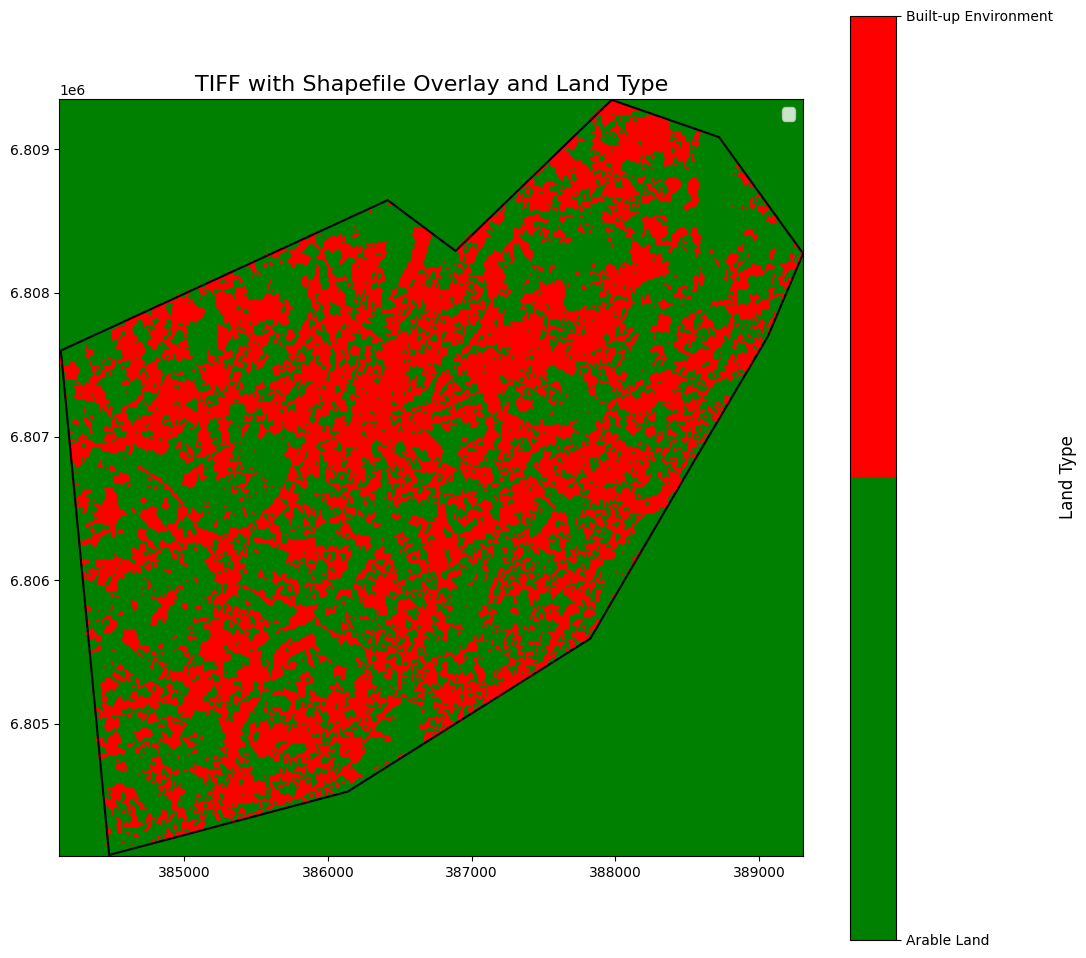

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap  # Add this line to import ListedColormap
# File paths
tiff_file = "/content/drive/MyDrive/Annual_images_mode/annual_mode_2017.tif"
shapefile = "/content/drive/MyDrive/Khandisa_croped/Khandisa_crop.shp"

# Load the TIFF file
with rasterio.open(tiff_file) as src:
    tiff_data = src.read(1)  # Read the first band
    tiff_bounds = src.bounds  # Get the bounds of the raster
    tiff_crs = src.crs  # Get the coordinate reference system

# Load the shapefile
shapes = gpd.read_file(shapefile)

# Ensure the shapefile is in the same CRS as the TIFF
if shapes.crs != tiff_crs:
    shapes = shapes.to_crs(tiff_crs)

# Create a custom colormap: 0 -> green, 1 -> red
cmap = ListedColormap(["green", "red"])
cbar_labels = {0: "Arable Land", 1: "Built-up Environment"}

# Plot the TIFF file with the custom colormap
fig, ax = plt.subplots(figsize=(12, 12))
tiff_img = ax.imshow(tiff_data, cmap=cmap, extent=(tiff_bounds.left, tiff_bounds.right, tiff_bounds.bottom, tiff_bounds.top))
ax.set_title("TIFF with Shapefile Overlay and Land Type", fontsize=16)

# Add the colorbar with custom labels
cbar = plt.colorbar(tiff_img, ax=ax, ticks=[0, 1])
cbar.ax.set_yticklabels([cbar_labels[0], cbar_labels[1]])
cbar.set_label("Land Type", fontsize=12)

# Overlay the shapefile
shapes.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.5, label="Region Boundaries (Black)")

# Add a legend for the shapefile layers
plt.legend(loc="upper right", fontsize=12, frameon=True)

# Display the plot
plt.show()



In [ ]:

# Path to your TIFF file
tiff_path = "/content/drive/MyDrive/UZ_Classified_images/Classified_2017-06-30.tif"

# Open the TIFF file
with rasterio.open(tiff_path) as src:
    # Read the first band (assuming single-band data)
    data = src.read(1)

    # Print some statistics
    print(f"Data type: {data.dtype}")
    print(f"Shape: {data.shape}")
    print(f"Min: {data.min()}, Max: {data.max()}")
    print(f"Pixel values: \n{data}")

Data type: int32
Shape: (527, 518)
Min: 0, Max: 1
Pixel values: 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]



# Post processing

In [ ]:
import pandas as pd
AL_FL_df = pd.read_csv("/content/drive/MyDrive/UZ_Classified_images/LandUse_Results.csv")

In [ ]:
# Convert the 'date' column to datetime
AL_FL_df['Date'] = pd.to_datetime(AL_FL_df['Date'])

In [ ]:
# Sort by the 'date' column in ascending order
AL_FL_df_sorted = AL_FL_df.sort_values(by='Date')

# Reset index (optional, for cleaner index)
AL_FL_df_sorted = AL_FL_df_sorted.reset_index(drop=True)

In [ ]:
AL_FL_df_sorted.head()

,Date,Farmland Area (km²),Built-up Area (km²)
0,2017-06-30,8.861939,7.337939
1,2017-07-05,8.703480,7.496397
2,2017-07-20,8.689413,7.510465
3,2017-07-25,8.793265,7.406613
4,2017-07-28,9.012582,7.187295


In [ ]:
# Convert the 'Date' column to datetime format
AL_FL_df_sorted['Date'] = pd.to_datetime(AL_FL_df_sorted['Date'])

In [ ]:
# Set the 'Date' column as the index
AL_FL_df_sorted.set_index('Date', inplace=True)

In [ ]:
# Group by month and calculate the mean
monthly_mean = AL_FL_df_sorted.resample('M').mean()


In [ ]:
monthly_mean.to_csv("/content/drive/MyDrive/UZ_Classified_images/Monthly_mean_results.csv")

Text(0.5, 1.0, 'Farmland Area Over Time')

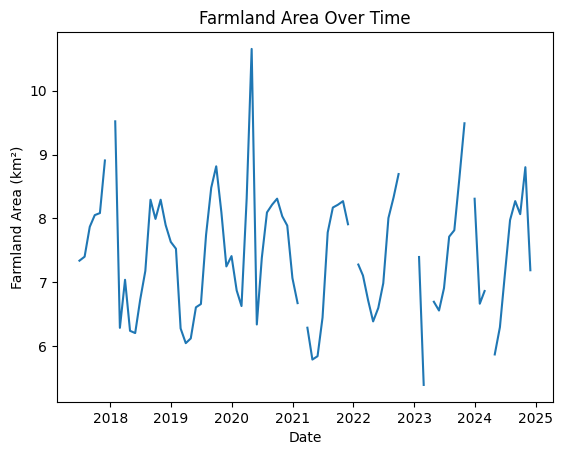

In [ ]:
plt.plot(monthly_mean['Built-up Area (km²)'])
plt.xlabel('Date')
plt.ylabel('Farmland Area (km²)')
plt.title('Farmland Area Over Time')

In [ ]:
df = monthly_mean.copy()

In [ ]:
# Data Interpolation
from scipy.interpolate import interp1d
import numpy as np

# Replace 'mydata' with 'df' to use the DataFrame that was loaded from the CSV
for col in ['Farmland Area (km²)', 'Built-up Area (km²)']:
    non_na_data = df.dropna(subset=[col])  # Use 'df' instead of 'mydata'
    # Convert index to numeric type before interpolation
    numeric_index = pd.to_numeric(non_na_data.index, errors='coerce')
    # Remove rows with invalid numeric index values (NaNs introduced by errors='coerce')
    non_na_data = non_na_data[~np.isnan(numeric_index)]
    numeric_index = numeric_index[~np.isnan(numeric_index)]
    f = interp1d(numeric_index, non_na_data[col], kind='cubic', fill_value="extrapolate")
    df[col] = f(np.arange(len(df)))  # Use 'df' instead of 'mydata'

In [ ]:
#df.head()

In [ ]:
# Set the 'Date' column as the index
#df.set_index('Date', inplace=True)
#df.head()

## Annual Modal Images

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.plot import reshape_as_image, reshape_as_raster
from collections import Counter
from datetime import datetime
from glob import glob

# Define the directory containing the TIFF files
input_directory = "/content/drive/MyDrive/UZ_Classified_images"
output_directory = "/content/drive/MyDrive/Annual_images_mode"

# Helper function to extract the year from a file name or metadata
def extract_year(file_path):
    filename = os.path.basename(file_path)
    # Extract the date part using a regular expression
    import re
    match = re.search(r'(\d{4}-\d{2}-\d{2})', filename)
    if match:
        date_str = match.group(1)
        return datetime.strptime(date_str, "%Y-%m-%d").year
    else:
        # Handle cases where the date format is not found
        print(f"Warning: Could not extract year from filename: {filename}")
        return None # or raise an exception, depending on your needs
# Helper function to calculate pixel-wise mode
def calculate_pixel_mode(stack):
    # Stack shape: (num_images, height, width)
    reshaped = stack.reshape(stack.shape[0], -1)  # Flatten height & width
    mode_result = np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=reshaped)
    return mode_result.reshape(stack.shape[1:])  # Reshape back to height & width

# Collect and organize files by year
files_by_year = {}
for file_path in glob(os.path.join(input_directory, "*.tif")):
    year = extract_year(file_path)
    if year not in files_by_year:
        files_by_year[year] = []
    files_by_year[year].append(file_path)

# Process each year
for year, file_paths in files_by_year.items():
    print(f"Processing year: {year}")

    # Read all monthly TIFFs for this year
    stacks = []
    profile = None  # To store metadata of the TIFFs

    for file_path in file_paths:
        with rasterio.open(file_path) as src:
            image_data = src.read(1)  # Read the first band (adjust if multi-band)
            stacks.append(image_data)
            if profile is None:
                profile = src.profile  # Get the profile of the first file

    # Convert list of arrays to a 3D NumPy array
    stack_array = np.stack(stacks, axis=0)  # Shape: (num_images, height, width)

    # Calculate the pixel-wise mode
    annual_mode = calculate_pixel_mode(stack_array)

    # Update the profile for the output file
    profile.update(dtype=rasterio.uint8, count=1, compress='lzw')

    # Save the result as a new TIFF
    output_path = os.path.join(output_directory, f"annual_mode_{year}.tif")
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(annual_mode.astype(rasterio.uint8), 1)

    print(f"Saved annual modal image for {year} to {output_path}")


Processing year: 2017
Saved annual modal image for 2017 to /content/drive/MyDrive/Annual_images_mode/annual_mode_2017.tif
Processing year: 2018
Saved annual modal image for 2018 to /content/drive/MyDrive/Annual_images_mode/annual_mode_2018.tif
Processing year: 2019
Saved annual modal image for 2019 to /content/drive/MyDrive/Annual_images_mode/annual_mode_2019.tif
Processing year: 2020
Saved annual modal image for 2020 to /content/drive/MyDrive/Annual_images_mode/annual_mode_2020.tif
Processing year: 2021
Saved annual modal image for 2021 to /content/drive/MyDrive/Annual_images_mode/annual_mode_2021.tif
Processing year: 2022
Saved annual modal image for 2022 to /content/drive/MyDrive/Annual_images_mode/annual_mode_2022.tif
Processing year: 2023
Saved annual modal image for 2023 to /content/drive/MyDrive/Annual_images_mode/annual_mode_2023.tif
Processing year: 2024
Saved annual modal image for 2024 to /content/drive/MyDrive/Annual_images_mode/annual_mode_2024.tif


### Spacial Temporal Analysis


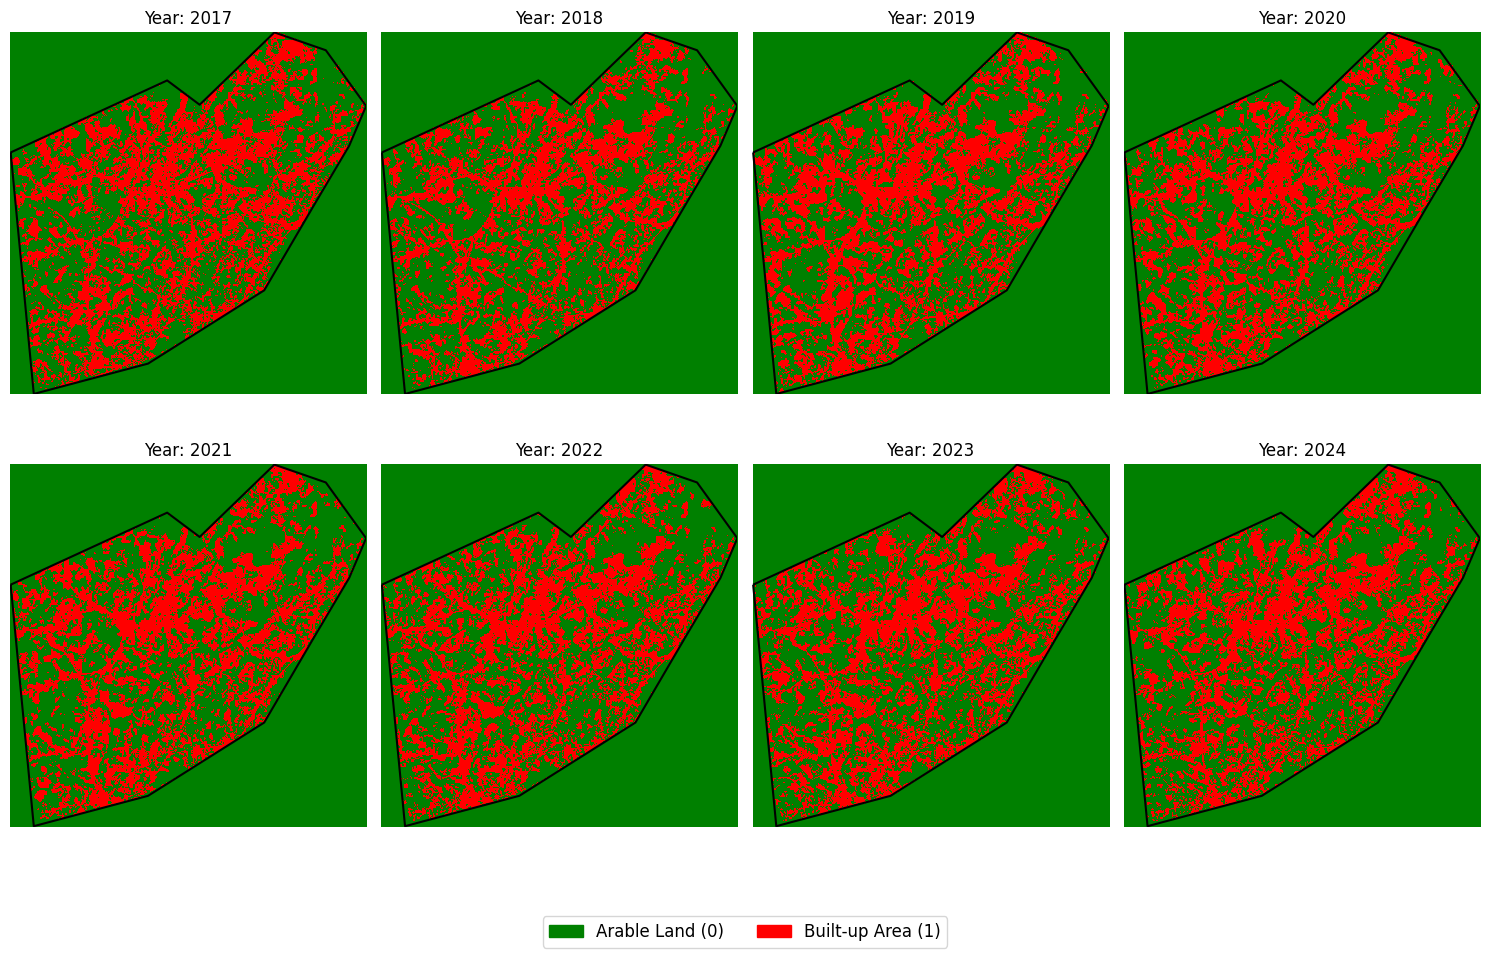

In [ ]:
import os
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.mask import mask
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Load the region of interest (ROI) shapefile
roi1_shapefile = "/content/drive/MyDrive/Khandisa_croped/Khandisa_crop.shp"
roi1 = gpd.read_file(roi1_shapefile)

# Set the directory containing the TIFF files
tiff_dir = "/content/drive/MyDrive/Annual_images_mode"
tiff_files = sorted([f for f in os.listdir(tiff_dir) if f.endswith('.tif')])

# Define the custom colormap for binary classes
cmap = ListedColormap(['green', 'red'])
labels = ['Arable Land (0)', 'Built-up Area (1)']
legend_patches = [Patch(color='green', label=labels[0]), Patch(color='red', label=labels[1])]

# Create a plot
fig, axes = plt.subplots(2, 4, figsize=(15, 10))  # Adjust as needed (e.g., 2 rows, 4 columns for 8 maps)
axes = axes.ravel()

# Loop through each TIFF file and plot it after masking with the shapefile
for i, tiff_file in enumerate(tiff_files):
    tiff_path = os.path.join(tiff_dir, tiff_file)

    with rasterio.open(tiff_path) as src:
        # Ensure the shapefile is in the same CRS as the TIFF
        if roi1.crs != src.crs:
            roi1 = roi1.to_crs(src.crs)  # Reproject if necessary

        # Mask the TIFF using the shapefile (ROI)
        out_image, out_transform = mask(src, roi1.geometry, crop=True)
        out_image = out_image[0]  # Take the first band if multi-band

        # Remove no-data values for visualization
        out_image = np.ma.masked_where(out_image == src.nodata, out_image)

        # Compute extent based on the transform of the masked image
        extent = (
            out_transform[2],
            out_transform[2] + out_transform[0] * out_image.shape[1],
            out_transform[5] + out_transform[4] * out_image.shape[0],
            out_transform[5]
        )

        # Plot the result
        ax = axes[i]
        img = ax.imshow(out_image, cmap=cmap, extent=extent, interpolation='nearest')

        # Add the ROI boundary in black
        roi1.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5)

        # Set title and turn off axis ticks
        ax.set_title(f"Year: {tiff_file[:4]}")  # Assuming filenames are like 'year_map.tif'
        ax.axis('off')

# Add a legend to the figure
fig.legend(handles=legend_patches, loc='lower center', ncol=2, fontsize='large', frameon=True)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space for the legend
#saving
plt.savefig("/content/drive/MyDrive/UZ_Classified_images/spatial_temporal_map.png", dpi=300, bbox_inches="tight")  # Save the figure
plt.show()
